# Tax units with lowest after-tax after-transfer incomes

This notebook analyzes the distribution of tax units and individuals with the lowest after-tax after-transfer incomes. It considers the trustworthiness of CPS data and C-TAM for the very bottom of the income scales, given the controversy around shares of Americans living in extreme poverty.

For example, this says there are 2.7M tax units and 1.3M children living on under $2/day. http://www.twodollarsaday.com/ has said:

> the number of American families living on $2.00 per person, per day, has skyrocketed to one and a half million American households, including about three million children.

But this analysis has come under some criticism for not properly accounting for transfer programs. 

*Data: CPS  |  Tax year: 2018  |  Author: Max Ghenis  |  Date run: 2018-02-27*

## Setup

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'0.16.1'

In [63]:
sns.set_style('whitegrid')

DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi']= DPI

mpl.rcParams['font.sans-serif'] = 'Roboto-Regular'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [4]:
recs = tc.Records.cps_constructor()
calc = tc.Calculator(records=recs, policy=tc.Policy())
calc.advance_to_year(2018)
calc.calc_all()

You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.


Create `DataFrame` of the items desired.

Which relevant columns are available? Totals, but really just care about != 0.

In [41]:
df = calc.dataframe(['s006',
                     'aftertax_income',
                     'nu18',
                     'XTOT'
                    ])
df.head()

,s006,aftertax_income,nu18,XTOT
0,239.46,42287.547869,0.0,2.0
1,202.59,20461.070670,2.0,3.0
2,255.35,96222.033747,0.0,1.0
3,178.36,26597.379609,1.0,2.0
4,270.80,41631.335096,0.0,2.0


## Preprocessing

Remove negatives.

In [48]:
df = df[df['aftertax_income'] >= 0]

Add after-tax income per person per day.

In [49]:
df['aftertax_income_pppd'] = df['aftertax_income'] / (df['XTOT'] * 365)
df['XTOT_s006'] = df['XTOT'] * df['s006']
df['nu18_s006'] = df['nu18'] * df['s006']

Add % of total.

In [84]:
df['XTOT_s006_pct'] = df['XTOT_s006'] / df['XTOT_s006'].sum()
df['s006_pct'] = df['s006'] / df['s006'].sum()
df['nu18_s006_pct'] = df['nu18_s006'] / df['nu18_s006'].sum()

Add after-tax income percentile by sorting and summing `cumsum` of normalized weight.

In [85]:
df.sort_values(by=['aftertax_income_pppd'], inplace=True)
df['XTOT_s006_cumsum'] = df['XTOT_s006'].cumsum()
df['s006_cumsum'] = df['s006'].cumsum()
df['nu18_s006_cumsum'] = df['nu18_s006'].cumsum()

df['XTOT_s006_cumpct'] = df['XTOT_s006_pct'].cumsum()
df['s006_cumpct'] = df['s006_pct'].cumsum()
df['nu18_s006_cumpct'] = df['nu18_s006_pct'].cumsum()

## Other sources

Create `DataFrame` of other sources:

* [Consumer Expenditure Survey](https://www.bls.gov/cex/), used by [Smith and Chandy](https://www.brookings.edu/wp-content/uploads/2016/06/How-Poor-are-Americas-Poorest.pdf) of Brookings.

In [101]:
ce = pd.DataFrame({'x': [2, 4], 'y': [0.0007, 0.0022]})

## Analysis

People vs other sources.

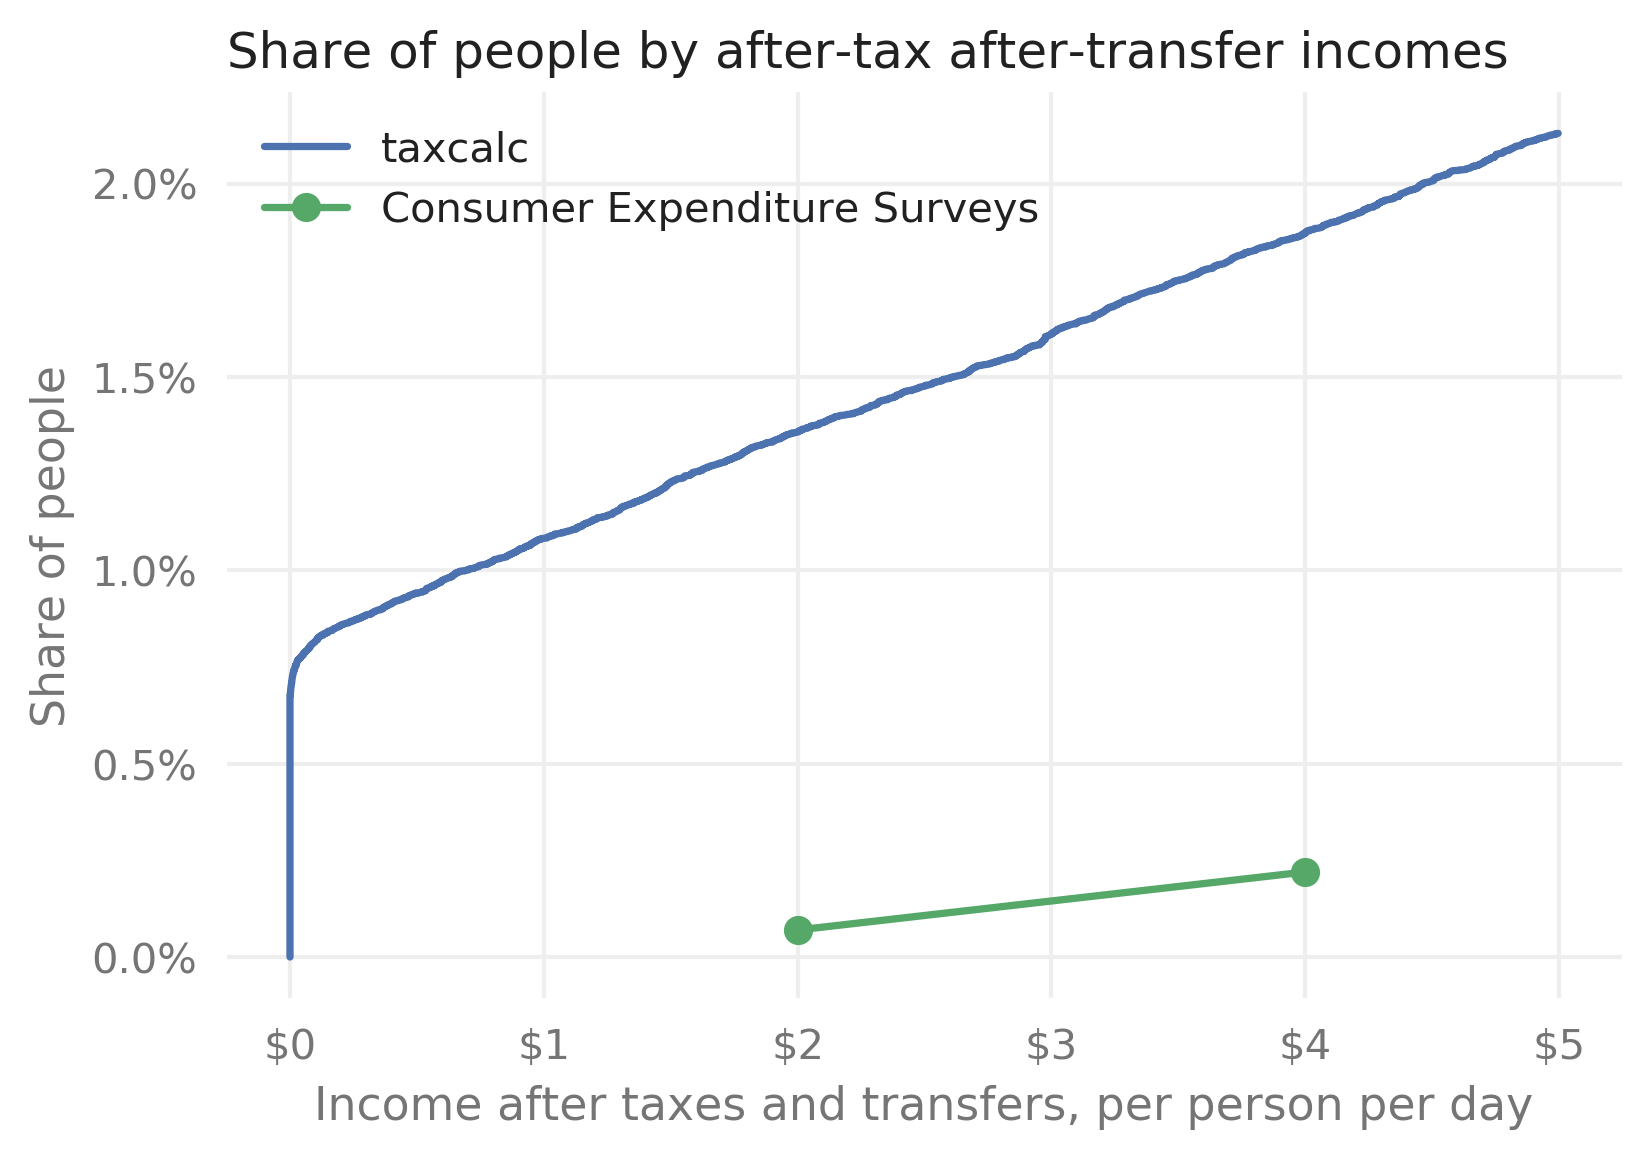

In [109]:
ax = df[df['aftertax_income_pppd'] <= 5].plot(
    x='aftertax_income_pppd', y=['XTOT_s006_cumpct'])
ce.plot(x='x', y='y', marker='o', ax=ax)
ax.legend(['taxcalc', 'Consumer Expenditure Surveys'])
ax.grid(color='#eeeeee')
sns.despine(left=True, bottom=True)
ax.set(xlabel='Income after taxes and transfers, per person per day',
       ylabel='Share of people')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: '$' + format(int(x))))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.title('Share of people by after-tax after-transfer incomes', loc='left')
plt.show()

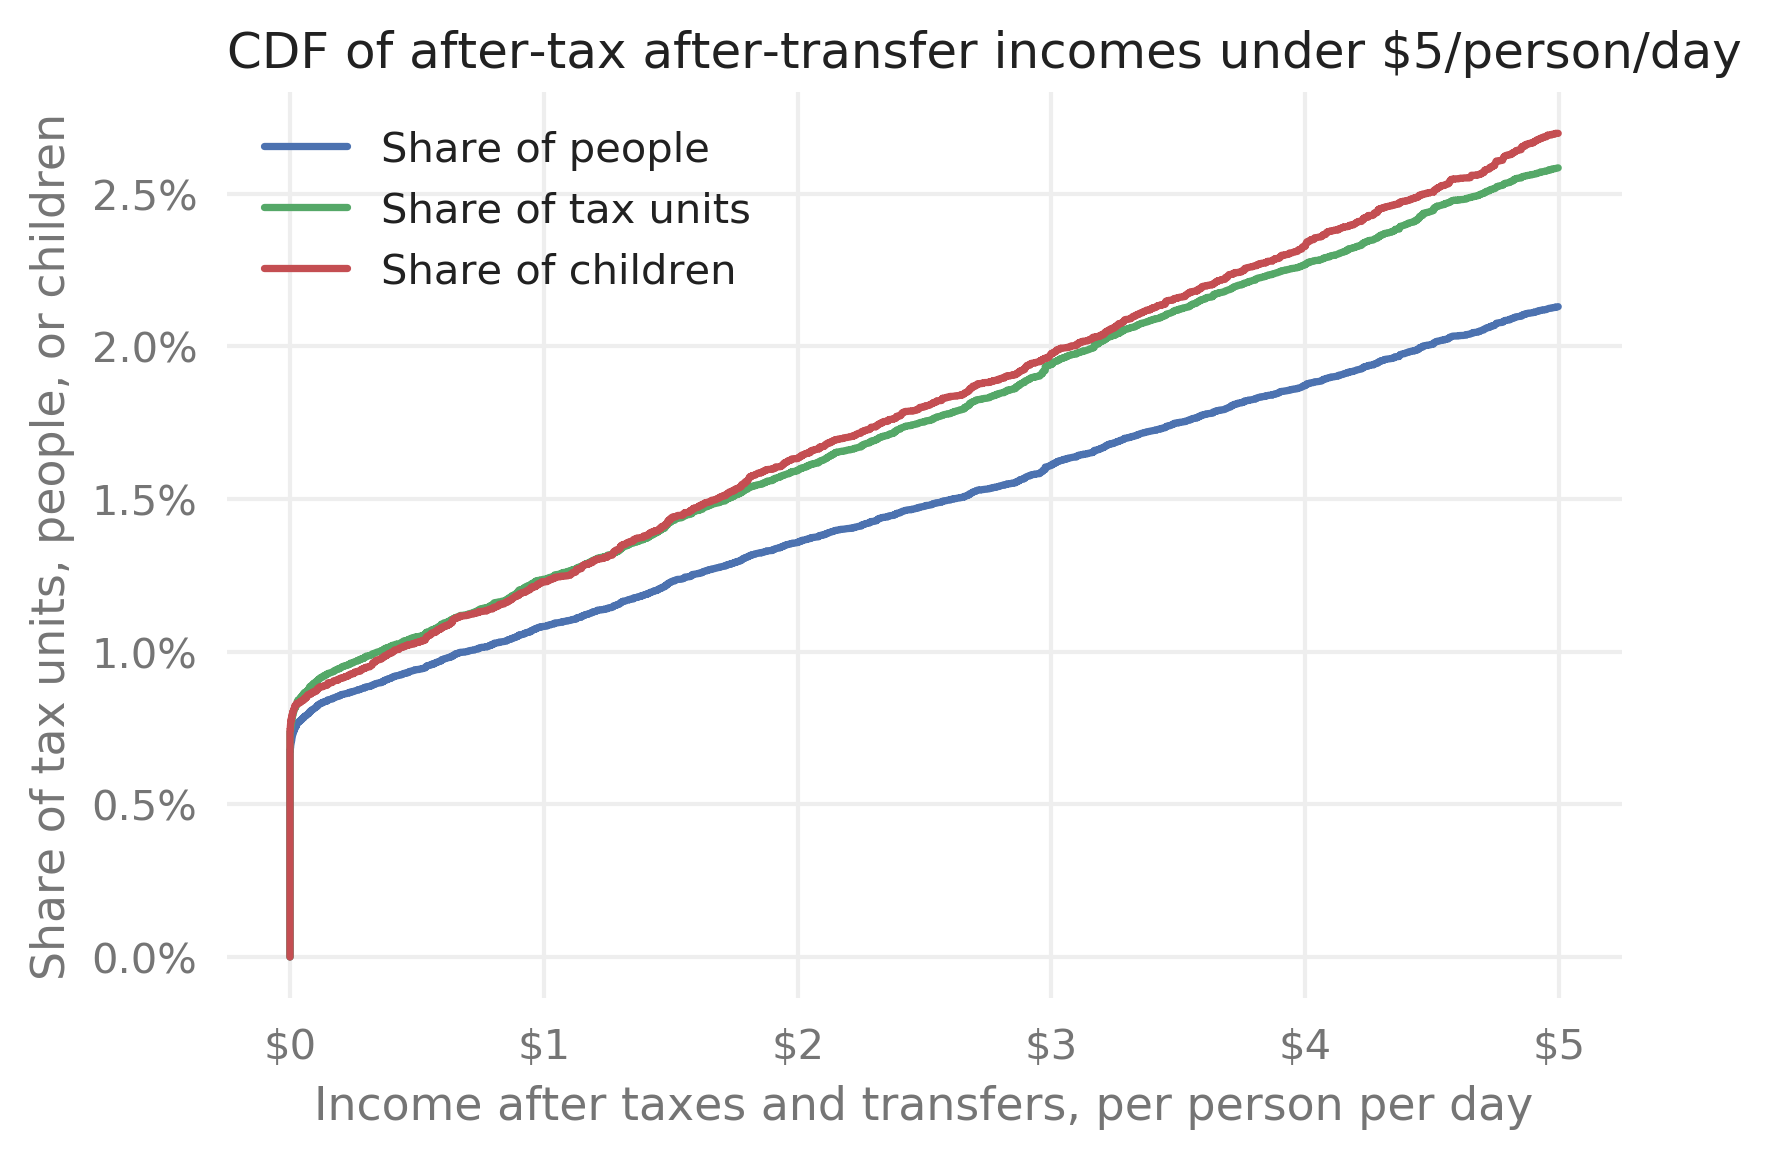

In [108]:
ax = df[df['aftertax_income_pppd'] <= 5].plot(
    x='aftertax_income_pppd', 
    y=['XTOT_s006_cumpct', 's006_cumpct', 'nu18_s006_cumpct'])
ax.legend(['Share of people', 'Share of tax units', 'Share of children'])
ax.grid(color='#eeeeee')
sns.despine(left=True, bottom=True)
ax.set(xlabel='Income after taxes and transfers, per person per day',
       ylabel='Share of tax units, people, or children')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: '$' + format(int(x))))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.title('CDF of after-tax after-transfer incomes under $5/person/day', loc='left')
plt.show()

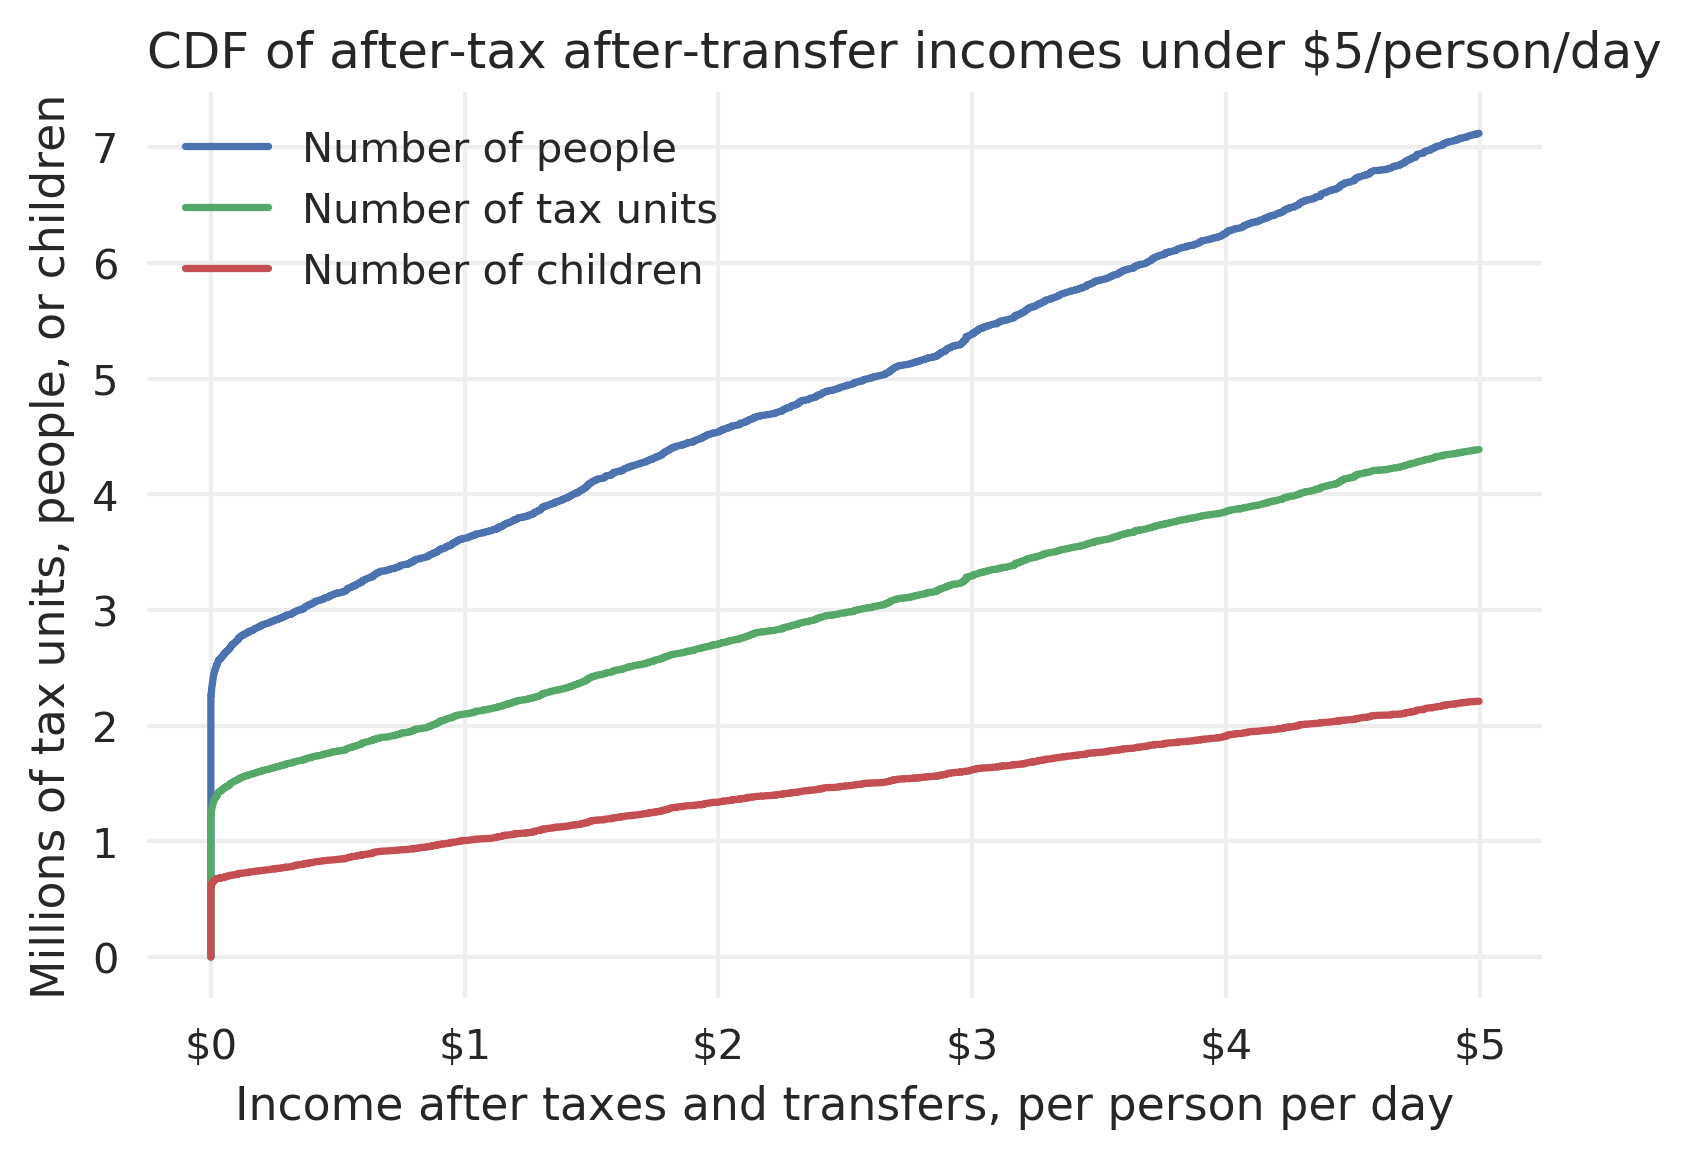

In [57]:
ax = df[df['aftertax_income_pppd'] <= 5].plot(
    x='aftertax_income_pppd', 
    y=['XTOT_s006_cumsum', 's006_cumsum', 'nu18_s006_cumsum'])
ax.legend(['Number of people', 'Number of tax units', 'Number of children'])
ax.grid(color='#eeeeee')
sns.despine(left=True, bottom=True)
ax.set(xlabel='Income after taxes and transfers, per person per day',
       ylabel='Millions of tax units, people, or children')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: '$' + format(int(x))))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: (y / 1e6).astype(int)))
plt.title('CDF of after-tax after-transfer incomes under $5/person/day', loc='left')
plt.show()

Look at $2/day threshold.

In [88]:
(df.loc[df['aftertax_income_pppd'] <= 2, 
        ['s006', 'XTOT_s006', 'nu18_s006']].sum() / 1e6).round(1)

s006         2.7027
XTOT_s006    4.5370
nu18_s006    1.3375
dtype: float64

In [92]:
(df.loc[df['aftertax_income_pppd'] <= 2, 
        ['s006_pct', 'XTOT_s006_pct', 'nu18_s006_pct']].sum() * 100).round(1)

s006_pct         1.6
XTOT_s006_pct    1.4
nu18_s006_pct    1.6
dtype: float64